# Multiple Variables
Continuing from the previous example, what if we want to do inference on something multi-dimensional?

In [3]:
# libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

In [5]:
np.random.seed(0)

Let's take the example of a wave moving from left to right.
What if only some points are observed? Can we infer other points? We might also want to include information about correlations between points we observe and infer.

First we will set up our model. We have a function that initialises a wave and one that iterates a wave forward in time by `nt` timesteps of size `dt`.

In [36]:
def initialise_wave(nx,dx):
    """ Returns initial wave
    """
    # initial conditions
    h = torch.ones(nx)     
    h[int(.5 / dx):int(1 / dx + 1)] = 2  # set h = 2 between 0.5 and 1 
    return h

def iterate_wave(speed,h,nt,dt,dx):
    """ Returns wave height after nt iterations, given initial height h
    """
    # propagate in time for nt steps, hn is the next step
    hn = torch.zeros(nx)
    for n in range(nt): 
        hn[0] = h[0]
        hn[1:] = h[1:] - speed * dt / dx * (h[1:] - h[0:-1])
        # set h to hn for next iteration
        h = hn
    return h

We define the model which samples from a latent variable, `speed`. The observed variable, `h`, is a function of this latent variable. The `iterate_wave` function could be swapped for more complex, non-linear function, possibly with more latent variables, to show how this could be applied to a more complicated example. 

In [40]:
pyro.clear_param_store()

def wave(guess,plot_wave=False,nx_data = 10,inds=range(10)):
    """ what are input params  """
    # basic parameters (fixed)
    nx = 21  # try changing this number from 41 to 81 and Run All ... what happens?
    dx = 2 / (nx-1)
    nt = 10    #nt is the number of timesteps we want to calculate
    dt = .025  #dt is the amount of time each timestep covers (delta t)

    # get pyro distribution of speed
    speed = pyro.sample("speed", dist.Normal(guess, 0.25))
    # initial conditions
    h0 = initialise_wave(nx,dx)
    # iterate
    true_h = iterate_wave(speed,h0,nt,dt,dx)
    
    # observe with some measurement error
    obs_h = torch.zeros(nx)
    for i in pyro.plate("x_axis",nx):
        # each point on the x-axis is conditionally independent given the speed
        obs_h[i] = pyro.sample("h_{}".format(str(i)),dist.Normal(true_h[i],0.01))      # h[i] depends on x

    if (plot_wave):
        plt.plot(np.linspace(0, 2, nx), h0.numpy());
        plt.plot(np.linspace(0, 2, nx), obs_h.numpy());

    return(speed,obs_h)


Let's check how the output varies if we sample multiple times.

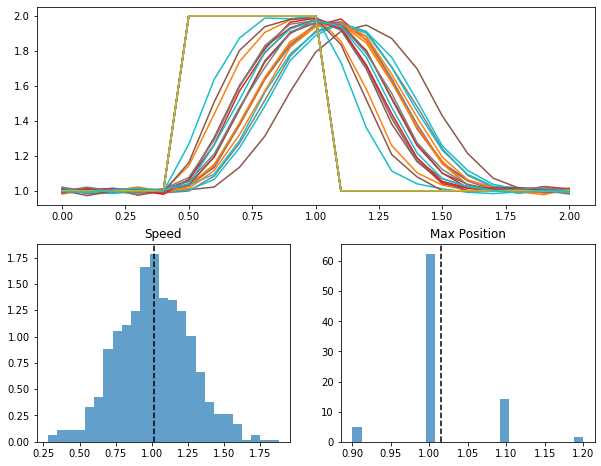

In [79]:
guess = 1.
speed_uncond,max_pos_uncond = [],[]
fig = plt.figure(figsize=(10,8));
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2);
for i in range(1000):
    plot_wave = True if i < 20 else False
    speed,h=wave(guess, plot_wave=plot_wave)
    speed_uncond.append(speed)
    max_pos_uncond.append(torch.argmax(h))

ax1 = plt.subplot2grid((2, 2), (1, 0));
ax1.hist(speed_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_uncond), c="k", ls="--");
plt.title("Speed");
ax2 = plt.subplot2grid((2, 2), (1, 1));
ax2.hist(max_pos,25, density=True, alpha=0.7);
ax2.axvline(np.mean(max_pos),c="k",ls="--")
plt.title("Max Position");


We observe the wave at a few points around the peak (copy and pasted from an example wave that had speed 0.6828)

tensor([1.0039, 0.9944, 1.1013, 2.0069, 0.9912, 0.9876, 1.7065, 1.5992, 0.9996,
        1.0008])


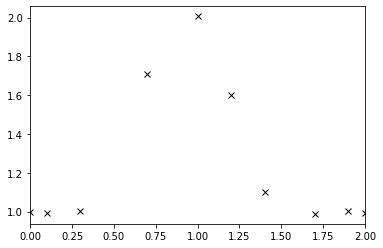

In [81]:
observed_speed,h = wave(guess, plot_wave=False)

# Pick some random points that we observe
observed_inds = np.random.choice(len(h),size=10,replace=False)
# TEMPORARILY FIX THIS
observed_inds = [3, 20, 14, 10,  1, 17,  7, 12,  0, 19]
observed_h = ([h[i].item() if i in observed_inds else None for i in range(nx) ])
observed_h = h[observed_inds]
print(observed_h)

# Put into data dictionary with named labels
keys = ["h_{}".format(str(i)) for i in observed_inds]
data = dict(zip(keys, observed_h))
# data = {"h_c":observed_h}
# Plot
plt.plot(np.linspace(0,2,nx)[observed_inds],observed_h.numpy(),'kx');
plt.axis(xmin=0.,xmax=2);

In [82]:
print(observed_inds)

[3, 20, 14, 10, 1, 17, 7, 12, 0, 19]


In [83]:
print(data)

{'h_3': tensor(1.0039), 'h_20': tensor(0.9944), 'h_14': tensor(1.1013), 'h_10': tensor(2.0069), 'h_1': tensor(0.9912), 'h_17': tensor(0.9876), 'h_7': tensor(1.7065), 'h_12': tensor(1.5992), 'h_0': tensor(0.9996), 'h_19': tensor(1.0008)}


In [99]:
conditioned_wave = pyro.condition(wave, data=data)

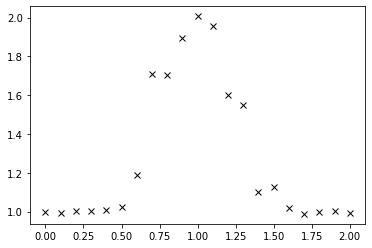

In [86]:
u,h=conditioned_wave(guess,plot_wave=False)
plt.plot(np.linspace(0,2,nx),h.numpy(),'kx');

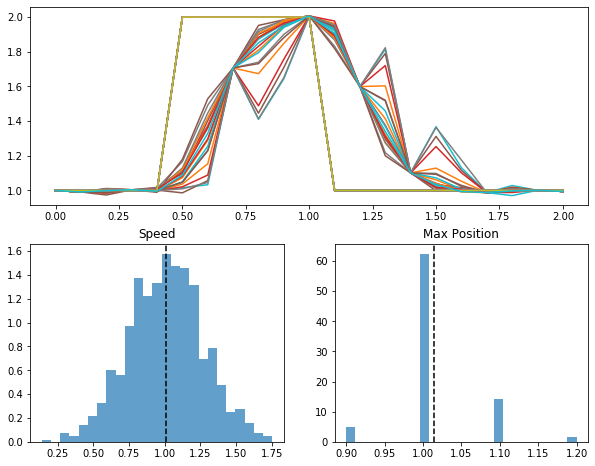

In [92]:
# Check this gives conditioned values fixed
guess = 1.
speed_uncond,max_pos_uncond = [],[]
fig = plt.figure(figsize=(10,8));
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2);
for i in range(1000):
    plot_wave = True if i < 20 else False
    speed, h = conditioned_wave(guess, plot_wave=plot_wave)
    speed_uncond.append(speed)
    max_pos_uncond.append(torch.argmax(h))

ax1 = plt.subplot2grid((2, 2), (1, 0));
ax1.hist(speed_uncond, 25, density=True, alpha=0.7);
ax1.axvline(np.mean(speed_uncond), c="k", ls="--");
plt.title("Speed");
ax2 = plt.subplot2grid((2, 2), (1, 1));
ax2.hist(max_pos,25, density=True, alpha=0.7);
ax2.axvline(np.mean(max_pos),c="k",ls="--")
plt.title("Max Position");


What if we condition on wave output, can we get the wave speed needed to get this output (using fixed wave speed from before, the correct value should be 0.5)?

Now create the guide, with parameters that should move us towards observed values of the wave.

In [107]:
from torch.distributions import constraints

def wave_parametrized_guide(guess, 
                            observed_inds=[3, 20, 14, 10,  1, 17,  7, 12,  0, 19],
                            plot_wave=False):
    nx = 21  
    # want to infer speed, and h_i at all values that we don't know them at
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(1.), 
                   constraint=constraints.positive)

    speed = pyro.sample("speed", dist.Normal(a,b))
    
    h = torch.zeros(nx)
    for i in pyro.plate("x_axis",nx):
        if (i in observed_inds):
            continue
        c_i = pyro.param("c_{}".format(i),torch.tensor(1.))
        d_i = pyro.param("d_{}".format(str(i)), torch.tensor(1.),
                   constraint=constraints.positive)
        h[i] = (pyro.sample("h_{}".format(str(i)),dist.Normal(c_i,d_i)) )
    
    if plot_wave:
        h = torch.detach(h)
        plt.plot(np.linspace(0,2,nx),h.numpy(),'bx')
    
    return(speed,h)


['a', 'b', 'c_3', 'd_3', 'c_20', 'd_20', 'c_14', 'd_14', 'c_10', 'd_10', 'c_1', 'd_1', 'c_17', 'd_17', 'c_7', 'd_7', 'c_12', 'd_12', 'c_0', 'd_0', 'c_19', 'd_19']


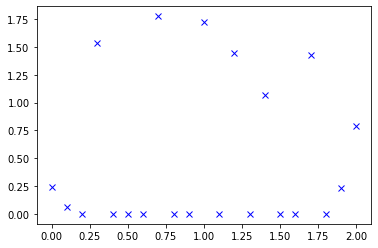

In [106]:
pyro.clear_param_store()
guess=1.
wave_parametrized_guide(guess,plot_wave=True)
param_names = list(pyro.get_param_store().get_all_param_names())
print(param_names)

(tensor(0.8733, grad_fn=<AddBackward0>),
 tensor([ 0.0000,  0.0000,  1.6653,  0.0000,  2.3781,  0.6080, -0.9962,  0.0000,
          3.2848,  1.0158,  0.0000,  0.5664,  0.0000,  0.4204,  0.0000,  1.7812,
          1.3978,  0.0000,  1.2726,  0.0000,  0.0000]))

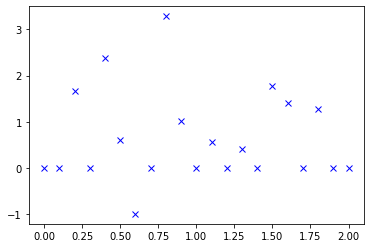

In [63]:
#pyro.clear_param_store()
wave_parametrized_guide(guess,plot_wave=True)

In [64]:
import pyro.poutine
traced=pyro.poutine.trace(wave_parametrized_guide)

In [65]:
param_names = list(pyro.get_param_store().get_all_param_names())

In [66]:
print(param_names)
print(len(param_names))

['a', 'b', 'd', 'c_2', 'c_4', 'c_5', 'c_6', 'c_8', 'c_9', 'c_11', 'c_13', 'c_15', 'c_16', 'c_18']
14


Iteration 0
[0.99900001 0.99900049 1.00100052 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


<Figure size 720x720 with 0 Axes>

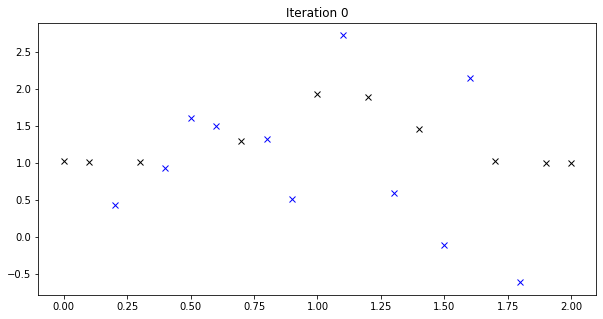

Iteration 10000
[9.92549956e-01 2.51679331e-01 2.20575762e+04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


<Figure size 432x288 with 0 Axes>

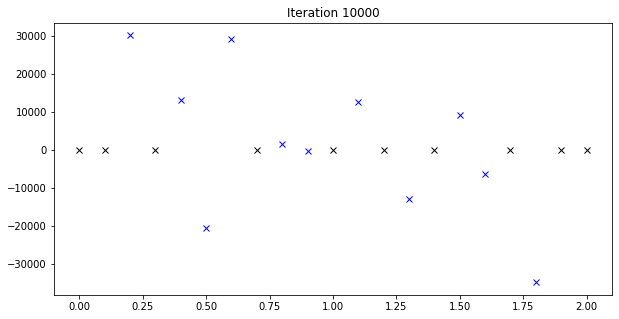

Iteration 20000
[9.82037365e-01 2.52163321e-01 4.85959808e+08 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


<Figure size 432x288 with 0 Axes>

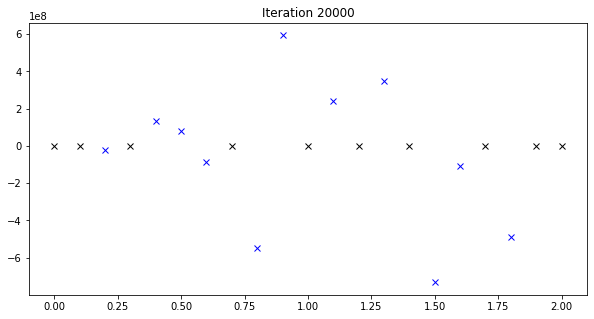

Iteration 30000
[1.00277281e+00 2.54785925e-01 1.58222296e+13 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


<Figure size 432x288 with 0 Axes>

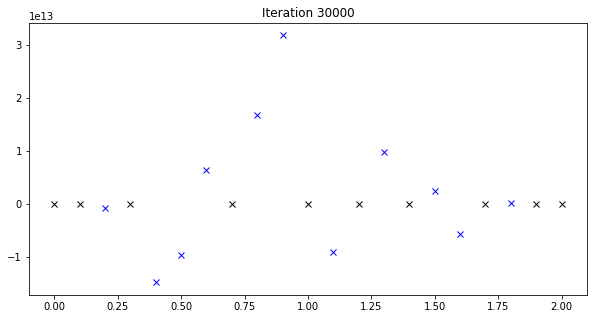

Iteration 40000
[9.95504856e-01 2.43719906e-01 2.78521070e+17 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


<Figure size 432x288 with 0 Axes>

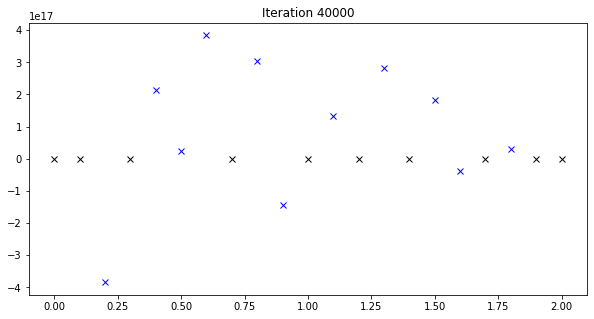

KeyboardInterrupt: 

In [67]:
from pyro.optim import Adam
pyro.clear_param_store()
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_wave, 
                     guide=wave_parametrized_guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO()
                     )

num_steps = 50000
# Save all parameters and losses
params = np.zeros((num_steps,len(param_names)))
losses = np.zeros(num_steps)
fig = plt.figure(figsize=(10,10))

plot_ind = 0
for t in range(num_steps):
    losses[t] = (svi.step(guess=1.))
    params[t,:] = [pyro.param(param_names[i]).item() 
                   for i in range(len(param_names))]
    
    if (t%10000==0.):
        print('Iteration {}'.format(str(t)))
        print(params[t,:])
        plt.clf();
        plt.figure(figsize=(10,5));
        speed,h=wave_parametrized_guide(guess)
        plt.plot(np.linspace(0,2,nx)[observed_inds],
         observed_h.numpy(),'kx');
        not_observed_inds = [i for i in range(nx) 
                     if i not in observed_inds]
        plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         h.detach().numpy()[not_observed_inds],'bx');
        plot_ind = plot_ind+1
        plt.title('Iteration {}'.format(str(t)));
        plt.show();



ax = plt.subplot2grid((2,5), (1, 0), colspan=4);
ax.plot(losses);
plt.title("ELBO");
plt.xlabel("step");
plt.ylabel("loss");


In [ ]:
print("a = ",pyro.param("a").item())
print("b = ", pyro.param("b").item())

fig = plt.figure()
ax1 = plt.subplot2grid((4, 1), (0, 0));
for i in range(nx):
    ax1.plot(params[:,0])
plt.title('a');

ax2 = plt.subplot2grid((4, 1), (1, 0));
for i in range(nx):
    ax2.plot(params[:,1])
plt.title('b');

ax3 = plt.subplot2grid((4, 1), (2, 0));
for i in range(nx):
    ax3.plot(params[:,2:(nx+2)])
plt.title('c');

ax4 = plt.subplot2grid((4, 1), (3, 0));
for i in range(nx):
    ax4.plot(params[:,(nx+2):])
plt.title('d');
plt.tight_layout();

In [ ]:
speed,h=wave_parametrized_guide(guess)
plt.plot(np.linspace(0,2,nx)[observed_inds],
         observed_h.numpy(),'kx');
not_observed_inds = [i for i in range(nx) 
                     if i not in observed_inds]
plt.plot(np.linspace(0,2,nx)[not_observed_inds],
         h.detach().numpy()[not_observed_inds],'bx');
plt.axis(xmin=0.,xmax=2);

In [62]:
param_store = pyro.get_param_store()
print(param_store.keys())
print(param_store['a'])
print(param_store['b'])

dict_keys(['a', 'b', 'c_2', 'd_2', 'c_4', 'd_4', 'c_5', 'd_5', 'c_6', 'd_6', 'c_8', 'd_8', 'c_9', 'd_9', 'c_11', 'd_11', 'c_13', 'd_13', 'c_15', 'd_15', 'c_16', 'd_16', 'c_18', 'd_18'])
tensor(0.9852, requires_grad=True)
tensor(0.2436, grad_fn=<AddBackward0>)


In [63]:
observed_speed

tensor(1.1073)

In [64]:
speed,h=wave_parametrized_guide(guess)